In [68]:
import os
import h5py
from pandas.core.frame import DataFrame
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset

# from CMAPSS.utils.transformations import MinMaxScaler

In [69]:
class CMAPSS(Dataset):
    """

    Attributes:
        kind: {'TSF', 'RUL'}
        split: {'train', 'test', 'test_plus'}
     
    """ 

    def __init__(
            self,
            dataset_name='FD001',
            dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
            steps_before=None,
            steps_after=None,
            transformations=[],
            kind='TSF',
            data_split='train',
            random_seed=42,
            val_size=0.2,
            rul_args={'return_last_rul': True, 'max_rul': 125},
            return_idx=False,
            drop_sensors=None,
    ):
    
        super().__init__()

        self.dataset_name = dataset_name
        self.dir_path = dir_path
        self.data_split = data_split
        self.kind = kind

        self.random_seed = random_seed
        self.val_size = val_size

        self.index_names = ['unit_idx', 'time_cycles']
        self.setting_names = ['setting_1', 'setting_2', 'setting_3']
        self.sensor_names = ['s_{}'.format(i) for i in range(1,22)]
        
        self.steps_before = steps_before
        self.steps_after = steps_after
        self.transformations = transformations

        self.rul_args = rul_args

        if drop_sensors is None:
            self.drop_sensors = self.get_drop_sensors()
        else:
            self.drop_sensors = drop_sensors

        self.df = self.load_data()

        self.num_features = 21 - len(self.drop_sensors)

        if self.steps_before is not None and self.steps_after is not None: 
            self.index_map = self._getindexmap()

        self.return_idx = return_idx

        self.check_parsed_args()

    def check_parsed_args(self):
        if self.kind == 'RUL':
            assert self.steps_after == 0, 'steps_after has to be set to 0'
            # assert self.steps_before is not None
        
    def __len__(self):

        if self.steps_before is None or (self.kind == 'RUL' and self.data_split == 'test'):
            return self.get_num_units()
        else:
            return len(self.index_map)

    def _getindexmap(self):
        index_map = dict()
        # num_units = self.get_num_units()
        
        # assert np.isin(self.df['unit_idx'].unique(), range(num_units)).all()

        unit_ids = self.df['unit_idx'].unique()
        
        idx_count = 0
        for unit_idx in unit_ids:
            unit_seq = self.df[self.df['unit_idx'] == unit_idx]
            max_offset = len(unit_seq) - self.steps_before - self.steps_after
            for offset in range(max_offset+1):
                curr_timeidx = offset + self.steps_before - 1
                index_map[idx_count] = [unit_idx, curr_timeidx]
                idx_count += 1
        return index_map

    def get_num_units(self):
        return len(self.df.groupby(by="unit_idx"))

    def __getitem__(self, index):

        if index >= len(self): raise IndexError

        if self.kind == 'TFS':
            return self._getitem_TSF(index)
        elif self.kind == 'RUL':
            return self._getitem_RUL(index, **self.rul_args)
        else:
            raise ValueError('Not supported kind')

    def _getitem_TSF(self, index):
        if self.steps_before is None and self.steps_after is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(index)
        else:          
            # get cropped sequence
            seq_df = self._get_crop_seq(index)

        drop_columns = self.index_names + self.setting_names
        seq_df.drop(labels=drop_columns, axis=1, inplace=True)

        res_seq = np.array(seq_df)

        for tranform in self.transformations:
            res_seq = tranform(res_seq)

        if self.steps_before is None and self.steps_after is None:
            return res_seq

        else:
            input_seq = res_seq[:self.steps_before]
            gt_seq = res_seq[self.steps_before: self.steps_before + self.steps_after] 
            return input_seq, gt_seq

    def _getitem_RUL(self, index: int, return_last_rul=True, **kwargs):

        if self.steps_before is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(self.df['unit_idx'].unique()[index])
        elif self.data_split in ['train', 'val', 'test_plus']:
            # get cropped sequence
            seq_df = self._get_crop_seq(index)
        elif self.data_split == 'test':
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(self.df['unit_idx'].unique()[index])

            # get cropped sequence
            seq_df = seq_df.iloc[-self.steps_before:]

        drop_columns = self.index_names + self.setting_names
        seq_df = seq_df.drop(labels=drop_columns, axis=1)

        input_seq = np.array(seq_df.iloc[:, :-1])

        if return_last_rul:
            gt_rul = np.array(seq_df.iloc[-1, -1:])
        else:
            gt_rul = np.array(seq_df.iloc[:, -1:])

        # for tranform in self.transformations:
        #     input_seq = tranform(input_seq)
        if hasattr(self, 'return_idx') and self.return_idx:
            return input_seq, gt_rul, index
        else:
            return input_seq, gt_rul

    def _get_unit_seq(self, unit_idx):
        unit_seq_df = self.df[self.df['unit_idx'] == unit_idx]
        return unit_seq_df

    def _get_crop_seq(self, index):
        unit_idx, curr_timeidx = self.index_map[index]
        unit_seq_df = self._get_unit_seq(unit_idx)
        
        # get current cropped sequence
        seq_df = unit_seq_df[curr_timeidx - self.steps_before + 1 : curr_timeidx + self.steps_after + 1]
        return seq_df

    def get_drop_sensors(self):
    
        drop_sensors = {
            'FD001': ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19'],
            'FD002': [],
            'FD003': ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19'],
            'FD004': []
        }

        return drop_sensors[self.dataset_name]


    def load_data(self):

        if self.data_split in ['train', 'val']:
            filename = 'train_' + self.dataset_name + '.txt'
        elif self.data_split in ['test', 'test_plus']:
            filename = 'test_' + self.dataset_name + '.txt'
        else:
            raise ValueError

        col_names = self.index_names + self.setting_names + self.sensor_names
        # filename = 'train' + self.dataset_name + '.txt'
        df = pd.read_csv(os.path.join(self.dir_path, filename), header=None, sep='\s+', names=col_names)
        df['unit_idx'] -= 1
        df = self.add_remaining_useful_life(df)

        df = df.drop(labels=self.drop_sensors, axis=1)

        for transfom in self.transformations:
            df.iloc[:, 5:-1] = transfom(df.iloc[:, 5:-1])

        unit_ids = df['unit_idx'].unique()

        # Shuffle units indices
        np.random.seed(self.random_seed)
        np.random.shuffle(unit_ids)

        if self.data_split == 'train':
            unit_ids_train = np.unique(unit_ids[:len(unit_ids)-int(len(unit_ids)*self.val_size)])
            df = df[df['unit_idx'].isin(unit_ids_train)]
        elif self.data_split == 'val':
            unit_ids_val = np.unique(unit_ids[len(unit_ids)-int(len(unit_ids)*self.val_size):])
            df = df[df['unit_idx'].isin(unit_ids_val)]

        if self.rul_args['max_rul']:
            df['RUL'][df['RUL'] > self.rul_args['max_rul']] = self.rul_args['max_rul']

        return df

    def add_remaining_useful_life(self, df):
        # Get the total number of cycles for each unit
        grouped_by_unit = df.groupby(by="unit_idx")

        max_cycle = grouped_by_unit["time_cycles"].max()

        if self.data_split in ['test', 'test_plus']:
            rul_test = pd.read_csv(os.path.join(self.dir_path, 'RUL_' + self.dataset_name + '.txt'),
                                   header=None, sep='\s+', names=['RUL'])
            max_cycle = max_cycle + rul_test['RUL'] 

        # Merge the max cycle back into the original frame
        # (Add max_cycle into the df)
        result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_idx', right_index=True)
        
        # Calculate remaining useful life for each row
        remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
        result_frame["RUL"] = remaining_useful_life
        
        # drop max_cycle as it's no longer needed
        result_frame = result_frame.drop("max_cycle", axis=1)
        return result_frame

In [70]:
class NCMAPSS(CMAPSS):
    def __init__(
            self,
            *args,
            dataset_name='DS02-006',
            dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
            # random_seed=42,
            # val_size=0.33,
            downsampling=10,
            **kwargs):

        # self.random_seed = random_seed
        # self.val_size = val_size
        self.downsampling = downsampling

        super().__init__(*args, dataset_name=dataset_name, dir_path=dir_path, **kwargs)

        self.num_features = 14 - len(self.get_drop_sensors())

    def __len__(self):

        if self.steps_before is None:
            return self.get_num_units()
        else:
            return len(self.index_map)

    def get_drop_sensors(self):
    
        drop_sensors = []

        return drop_sensors

    def downsample(self, df):
        downsampled_df = DataFrame(columns=df.columns)
        unit_ids = df['unit_idx'].unique()
        
        for unit_idx in unit_ids:
            df_ = df[df['unit_idx'] == unit_idx]
            df_ = df_.iloc[::self.downsampling, :]
            downsampled_df = pd.concat([downsampled_df, df_])
            
        return downsampled_df

    def load_data(self):

        filename = 'N-CMAPSS_' + self.dataset_name + '.h5'

        with h5py.File(os.path.join(self.dir_path, filename), 'r') as hdf:
            # Development set: Units: 2, 5, 10, 18, 18, 20
            if self.data_split in ['train', 'val']:
                X_s = np.array(hdf.get('X_s_dev'))
                Y = np.array(hdf.get('Y_dev'))           # RUL  
                A = np.array(hdf.get('A_dev'))           # Auxiliary: Shape: [*, 4]
            else:
                # Test set: Units; 11, 14, 15
                X_s = np.array(hdf.get('X_s_test'))
                A = np.array(hdf.get('A_test'))           # Auxiliary: Shape: [*, 4]
                Y = np.array(hdf.get('Y_test'))           # RUL  
            
            # Varnams
            
            X_s_var = np.array(hdf.get('X_s_var'))  # [b'T24', b'T30', b'T48', b'T50', b'P15', b'P2', b'P21', b'P24',
                                                    #  b'Ps30', b'P40', b'P50', b'Nf', b'Nc', b'Wf']

            # [b'unit', b'cycle', b'Fc', b'hs']: Fc and hs?? Fc: Flight class, hs: Health state
            A_var = np.array(hdf.get('A_var'))

            # from np.array to list dtype U4/U5
            X_s_var = list(np.array(X_s_var, dtype='U20')) # Unsigned int, 20 is bytes length
            A_var = list(np.array(A_var, dtype='U20'))

        df_X = DataFrame(data=X_s, columns=X_s_var)
        df_A = DataFrame(data=A, columns=A_var)
        df_Y = DataFrame(data=Y, columns=['RUL'])

        df_A = self.add_unit_idx(df_A)

        df = pd.concat([df_A, df_X, df_Y], axis=1)

        df = self.downsample(df)
        
        for transfom in self.transformations:
            df.iloc[:, 5:-1] = transfom(df.iloc[:, 5:-1])

        unit_ids = df['unit_idx'].unique()

        # Shuffle units indices
        np.random.seed(self.random_seed)
        np.random.shuffle(unit_ids)

        if self.data_split == 'train':
            unit_ids_train = np.unique(unit_ids[:len(unit_ids)-int(len(unit_ids)*self.val_size)])
            df = df[df['unit_idx'].isin(unit_ids_train)]
        elif self.data_split == 'val':
            unit_ids_val = np.unique(unit_ids[len(unit_ids)-int(len(unit_ids)*self.val_size):])
            df = df[df['unit_idx'].isin(unit_ids_val)]

        return df

    def add_unit_idx(self, df):
        df_idx = DataFrame(data=df['unit'].unique(), columns=['unit'])
        df_idx['unit_idx'] = df_idx.index
        df = df_idx.merge(df, left_on='unit', right_on='unit')

        return df

    def _getitem_RUL(self, index: int, return_last_rul=True, **kwargs):

        if self.steps_before is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(index)
        else:
            # get cropped sequence
            seq_df = self._get_crop_seq(index)

        input_seq = np.array(seq_df.iloc[:, 5:-1])

        if return_last_rul:
            gt_rul = np.array(seq_df.iloc[-1, -1:], dtype=float)
        else:
            gt_rul = np.array(seq_df.iloc[:, -1:])

        return input_seq, gt_rul


# if __name__ == "__main__":

    # dataset_train = NCMAPSS(steps_before=None, steps_after=0, kind='RUL', data_split='train',
    #                         transformations=[MinMaxScaler()], rul_args={'return_last_rul': True})

    # print(dataset_train[0])

    # dataset_val = NCMAPSS(steps_before=30, steps_after=0, kind='RUL', data_split='val',
    #                         transformations=[MinMaxScaler()], rul_args={'return_last_rul': False})

    # print(dataset_val[0])

    # dataset_test = NCMAPSS(steps_before=50, steps_after=0, kind='RUL', data_split='test',
    #                         transformations=[MinMaxScaler()],rul_args={'return_last_rul': True})

    # print(dataset_test[0])

    # dataset_train = PHM08(steps_before=15, steps_after=0, kind='RUL', data_split='train')

    # print(dataset_train[0])

    # dataset_val = PHM08(steps_before=None, steps_after=0, kind='RUL', data_split='val')

    # print(dataset_val[0])

    # dataset_test = PHM08(steps_before=None, steps_after=0, kind='RUL', data_split='test')

    # print(dataset_test[0])

    # dataset_dev = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='train', val_size=0,
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_dev[0])

    # dataset_train = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='train',
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_train[0])


    # dataset_train = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='val',
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_train[0])

    # dataset_test = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='test', return_idx=True) 

    # print(dataset_test[0])

    # dataset_test = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='test_plus', return_idx=True) 

    # print(dataset_test[0])

In [71]:
NASAdataset_df_train = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
                            downsampling=1).load_data()
NASAdataset_df_train = NASAdataset_df_train.astype(float)
NASAdataset_df_test = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set', data_split='test',
                            downsampling=1).load_data()
NASAdataset_df_test = NASAdataset_df_test.astype(float)

print(NASAdataset_df_train['unit'].tail())
print(NASAdataset_df_train['RUL'][0])
print(NASAdataset_df_test['unit'].tail())
# NASAdataset_df_train.describe()

5263442    20.0
5263443    20.0
5263444    20.0
5263445    20.0
5263446    20.0
Name: unit, dtype: float64
74.0
1253738    15.0
1253739    15.0
1253740    15.0
1253741    15.0
1253742    15.0
Name: unit, dtype: float64


In [113]:
NASAdataset_train = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
                            downsampling=1, kind='RUL', steps_after=0)

In [115]:
NASAdataset_train.df

,unit,unit_idx,cycle,Fc,hs,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,RUL
0,2.0,0,1.0,3.0,1.0,600.148034,1438.498187,1818.027714,1228.129848,15.806267,11.577097,16.046971,20.126624,331.293679,336.631827,12.629361,2160.926416,8591.37349,3.855337,74
1,2.0,0,1.0,3.0,1.0,600.055894,1438.350208,1817.682618,1227.879113,15.795477,11.568235,16.036017,20.113218,331.109867,336.446748,12.623033,2160.909333,8590.972866,3.852319,74
2,2.0,0,1.0,3.0,1.0,600.210756,1439.109101,1820.020627,1229.422522,15.807747,11.574866,16.048474,20.130956,331.753181,337.082502,12.637951,2161.819062,8593.031745,3.866201,74
3,2.0,0,1.0,3.0,1.0,600.369717,1439.24023,1819.188327,1228.538726,15.81636,11.578198,16.057218,20.146716,331.819136,337.162828,12.631509,2162.768666,8593.781545,3.863328,74
4,2.0,0,1.0,3.0,1.0,600.298227,1439.064004,1818.96354,1228.389046,15.807513,11.571593,16.048236,20.135888,331.626003,336.966936,12.624872,2162.619544,8593.2202,3.860818,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263442,20.0,5,66.0,3.0,0.0,567.846845,1286.087972,1549.487006,1126.363646,14.314363,11.970734,14.532349,16.908754,222.23732,226.607581,11.354816,1754.978021,8076.168288,2.214107,0
5263443,20.0,5,66.0,3.0,0.0,567.94265,1287.089618,1552.522723,1128.293601,14.32227,11.97277,14.540376,16.920754,222.956874,227.318482,11.37149,1756.479769,8079.087036,2.226891,0
5263444,20.0,5,66.0,3.0,0.0,568.241901,1288.541567,1555.489945,1129.695621,14.341053,11.978128,14.559445,16.951657,223.934067,228.302182,11.384707,1760.043718,8083.965798,2.241299,0
5263445,20.0,5,66.0,3.0,0.0,568.4626,1288.872381,1554.725363,1128.67378,14.353299,11.98093,14.571877,16.973923,224.122352,228.510961,11.381855,1762.353189,8085.691199,2.240604,0


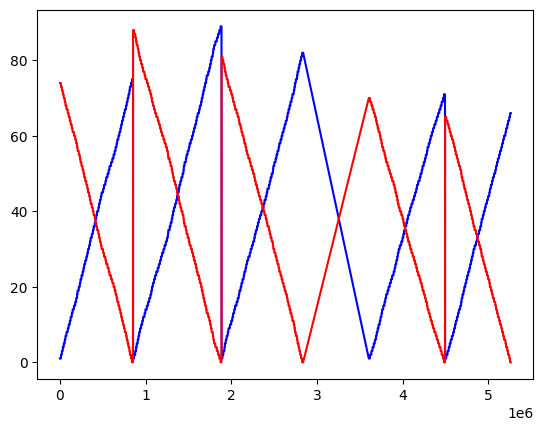

In [93]:
plt.plot(NASAdataset_df_train['cycle'], c='b')
plt.plot(NASAdataset_df_train['RUL'], c='r')

In [106]:
#consider single unit & single cycle & single unit in single flight
NASAdataset_df_train_u5 = NASAdataset_df_train[NASAdataset_df_train['unit'] == 5].copy()
NASAdataset_df_train_u5 = NASAdataset_df_train_u5.astype(float)

NASAdataset_df_train_c30 = NASAdataset_df_train[NASAdataset_df_train['cycle'] == 30].copy()
NASAdataset_df_train_c30 = NASAdataset_df_train_c30.astype(float)

NASAdataset_df_train_c70 = NASAdataset_df_train[NASAdataset_df_train['cycle'] == 70].copy()
NASAdataset_df_train_c70 = NASAdataset_df_train_c30.astype(float)

NASAdataset_df_train_u5_c30 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==30)].copy()
NASAdataset_df_train_u5_c30 = NASAdataset_df_train_u5_c30.astype(float)

NASAdataset_df_train_u5_c70 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==70)].copy()
NASAdataset_df_train_u5_c70 = NASAdataset_df_train_u5_c70.astype(float)

NASAdataset_df_train_u5_c89 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==89)].copy()
NASAdataset_df_train_u5_c89 = NASAdataset_df_train_u5_c89.astype(float)

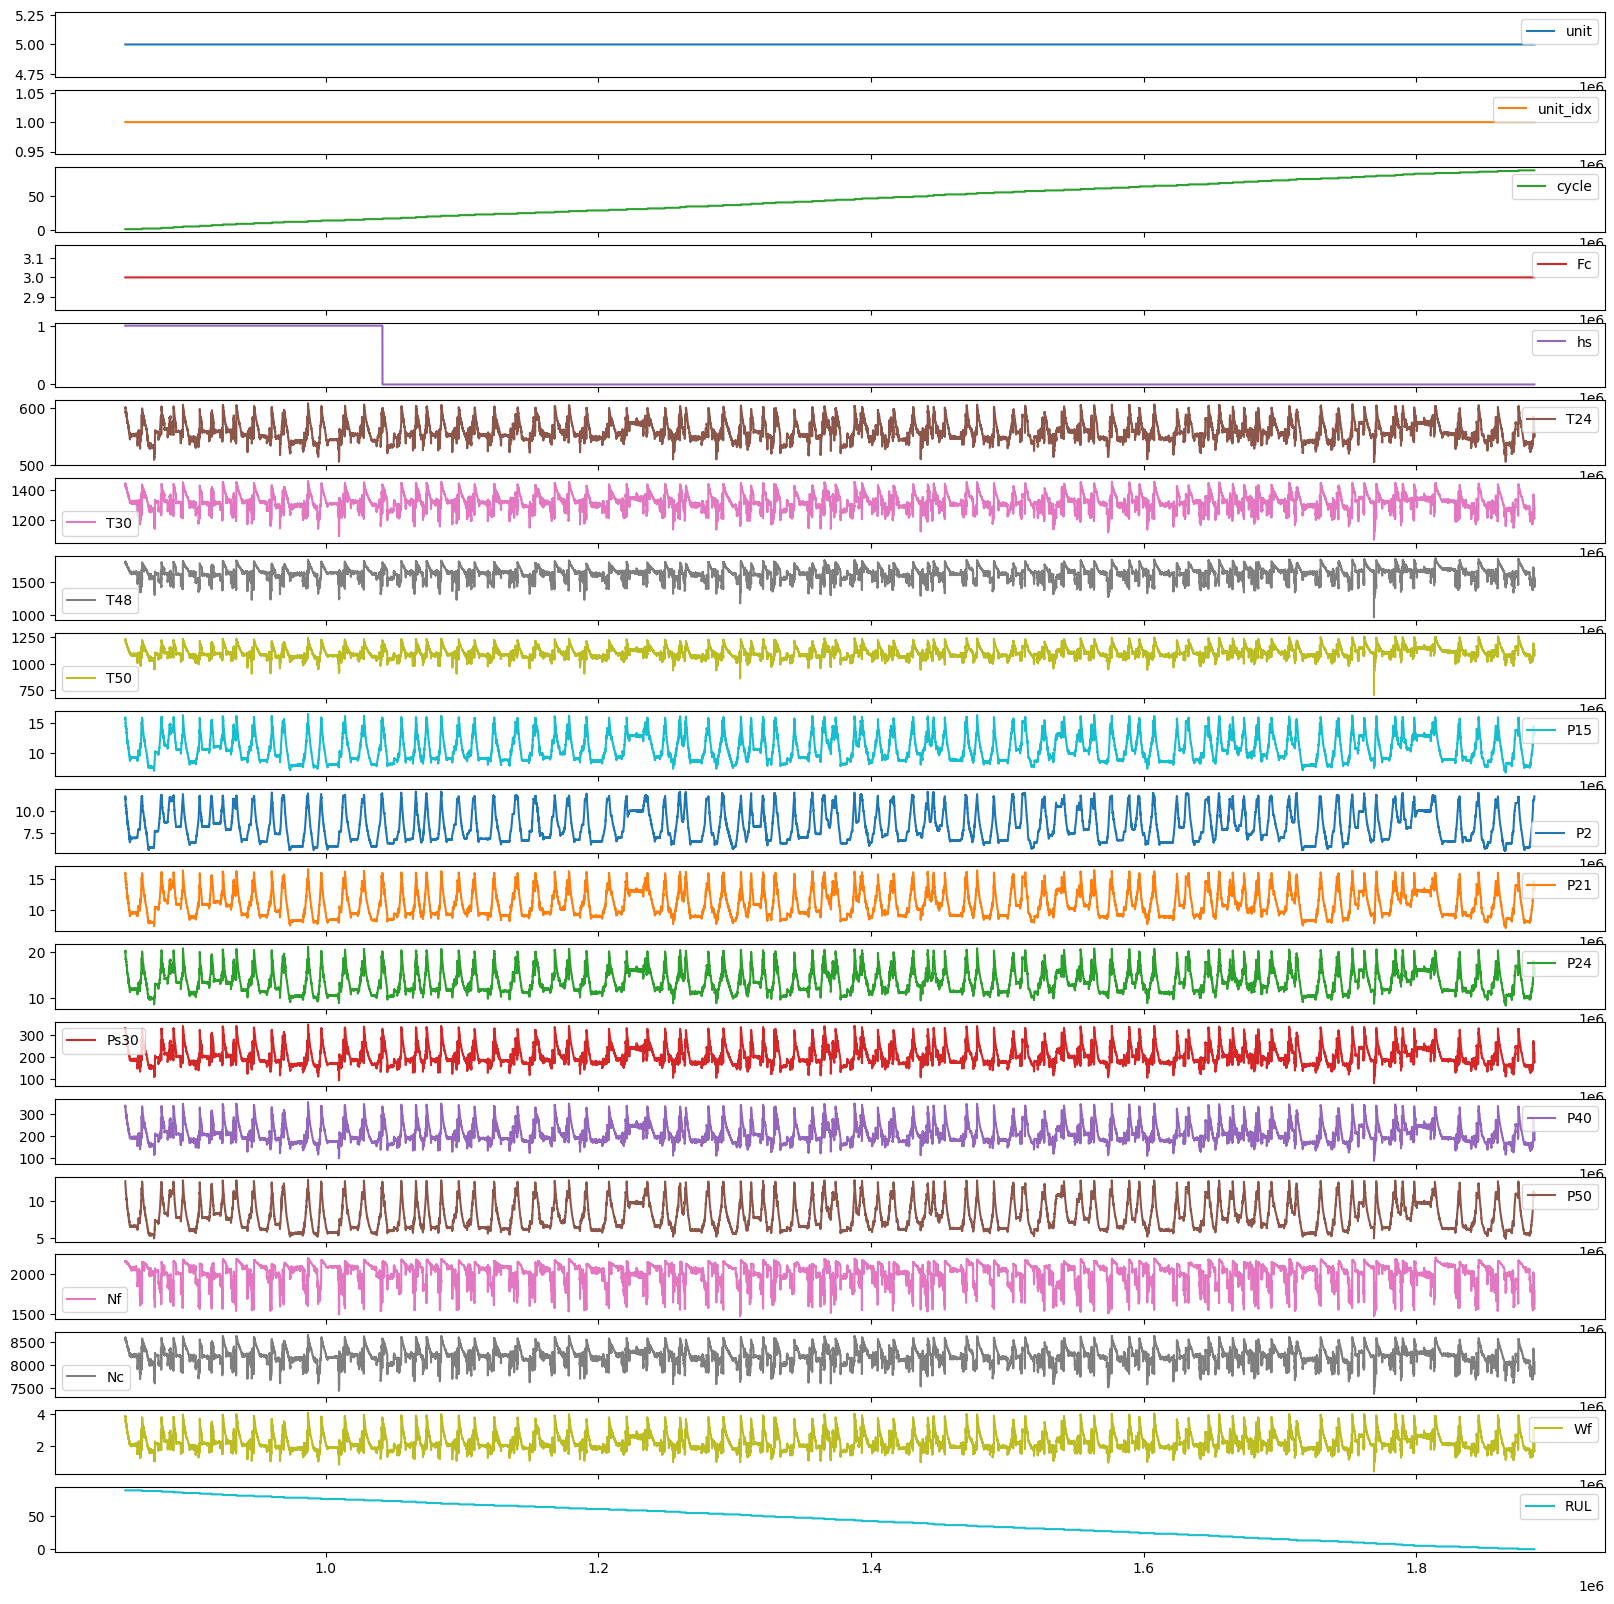

In [88]:
u5 = NASAdataset_df_train_u5.plot(subplots=True, figsize=(20,20))

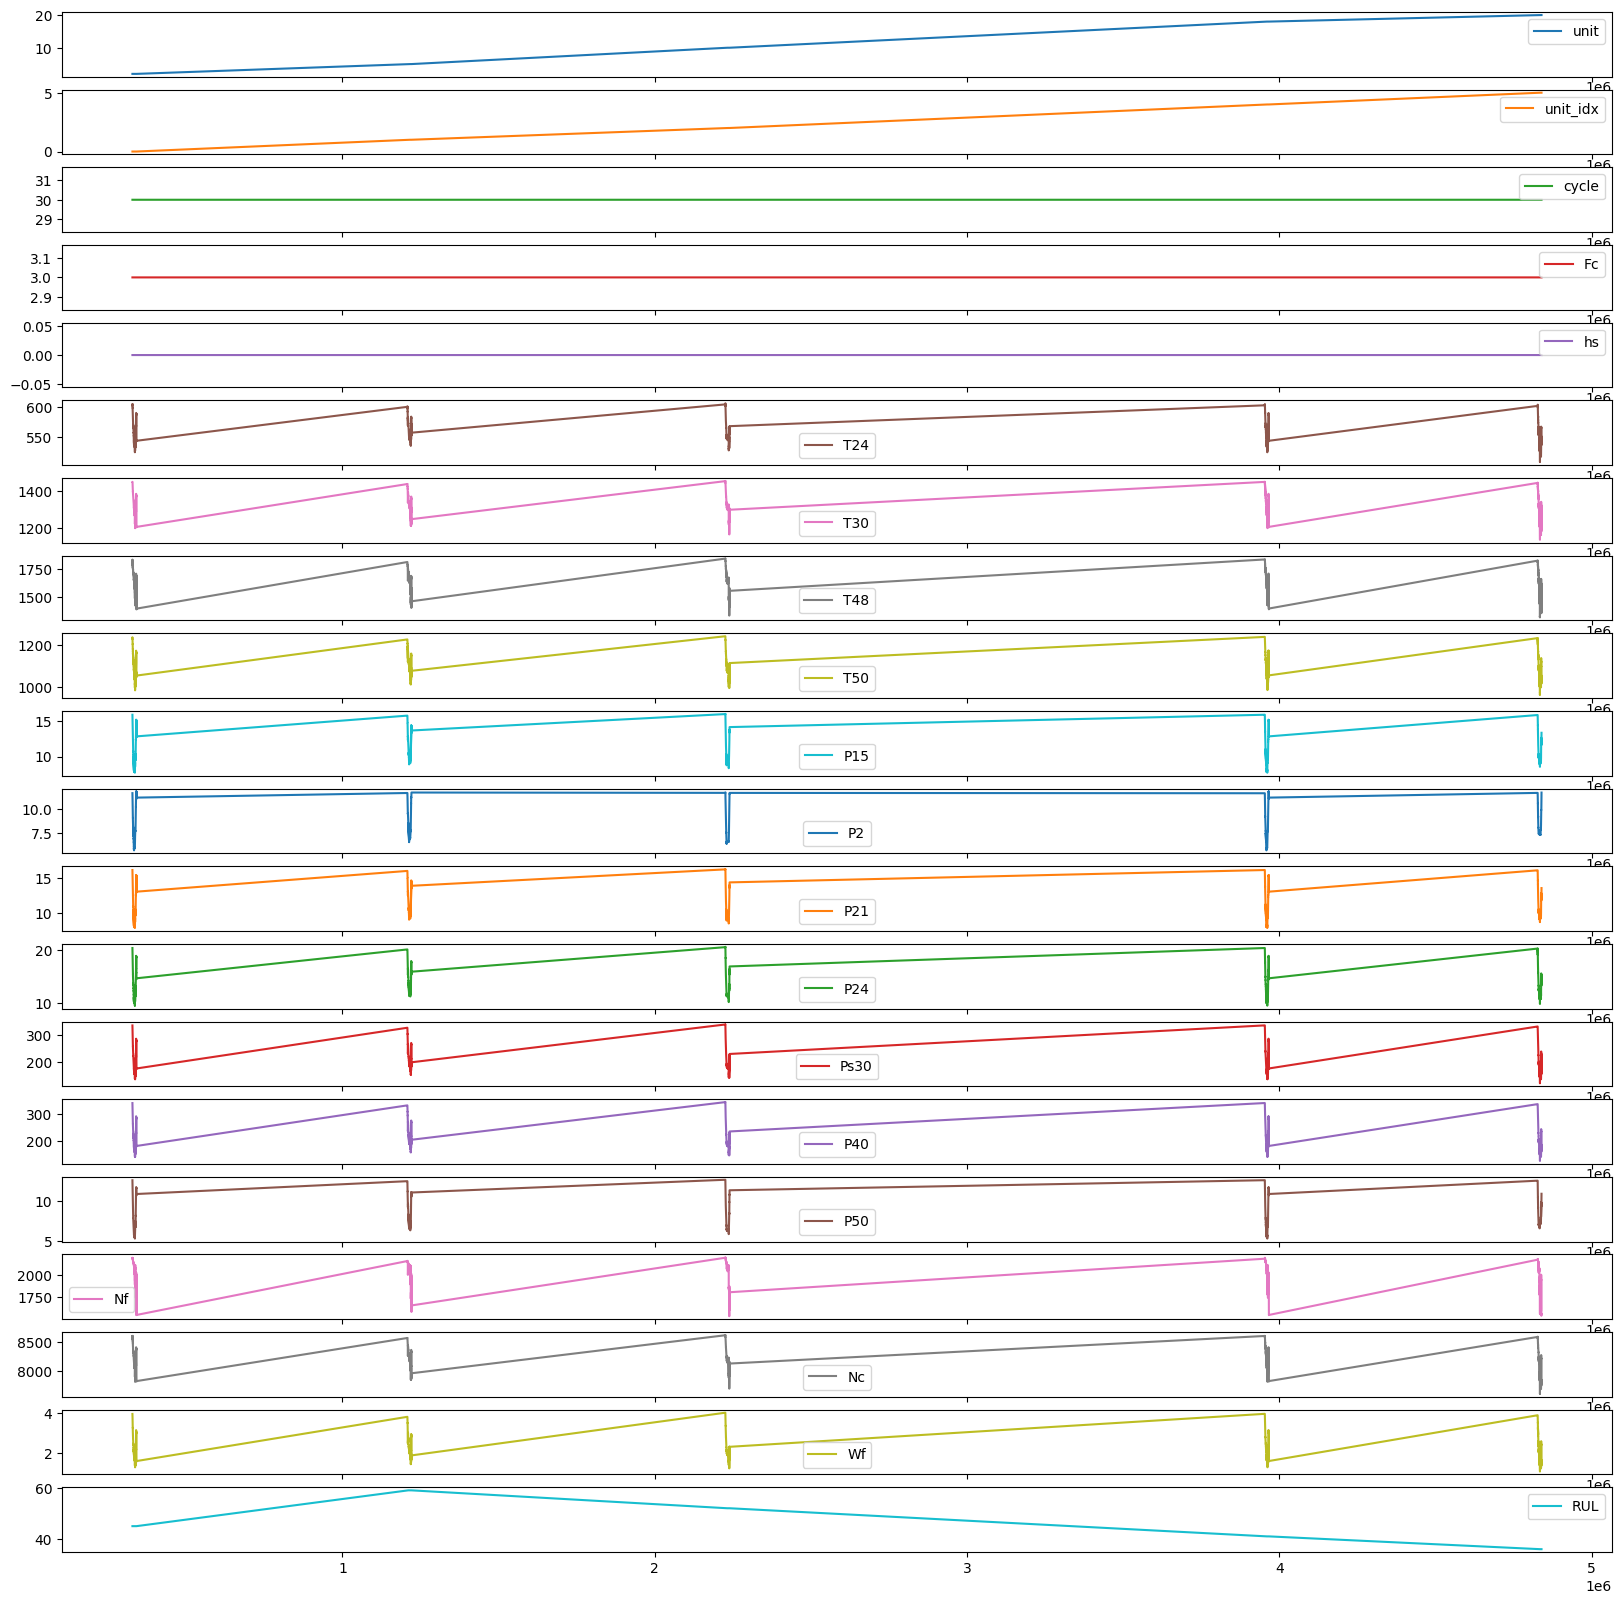

In [89]:
c30 = NASAdataset_df_train_c30.plot(subplots=True, figsize=(20,20))

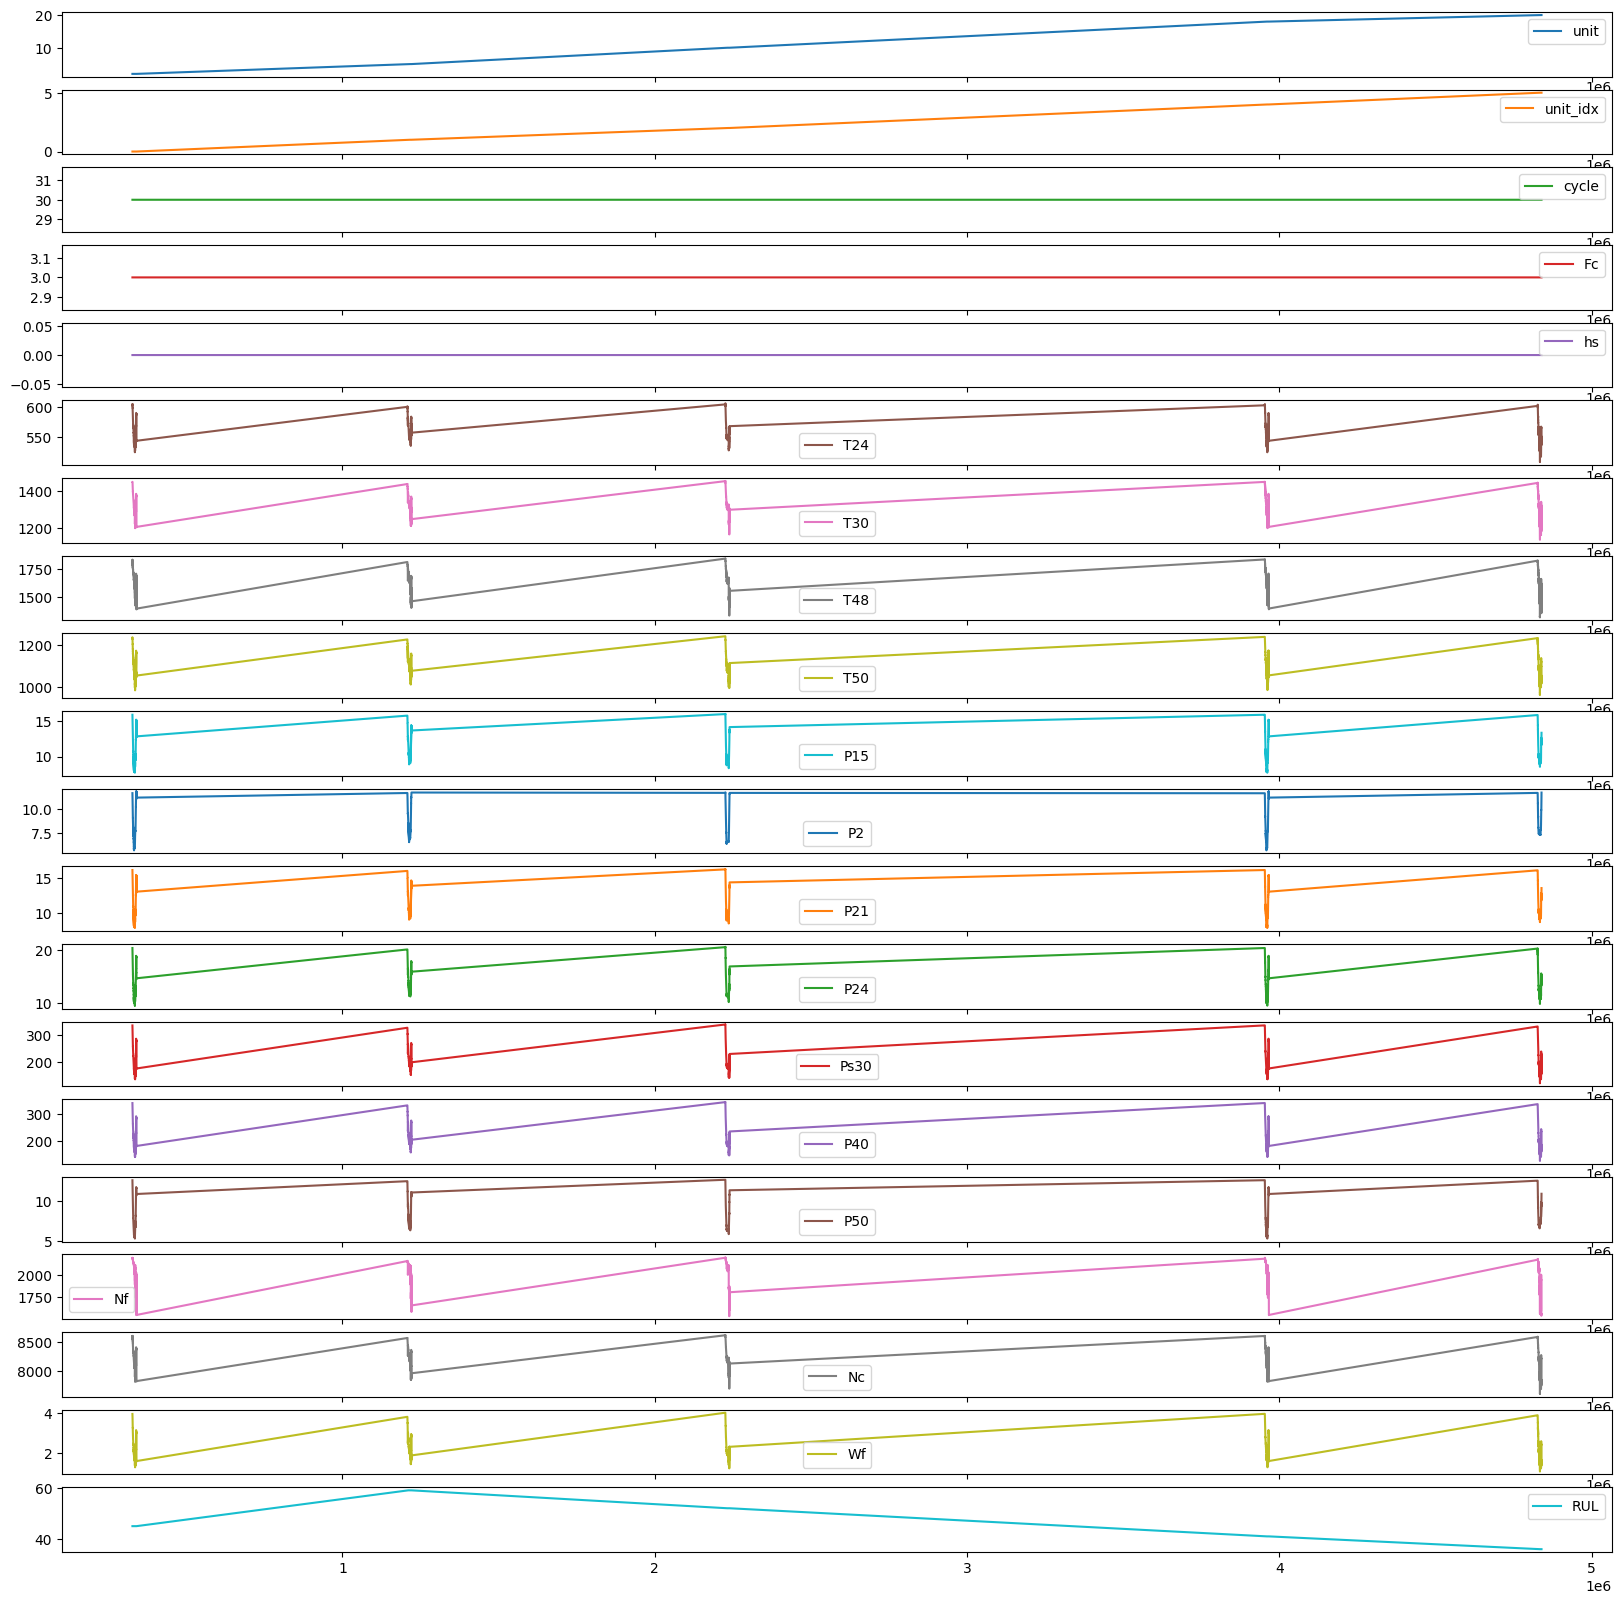

In [97]:
c70 = NASAdataset_df_train_c70.plot(subplots=True, figsize=(20,20))

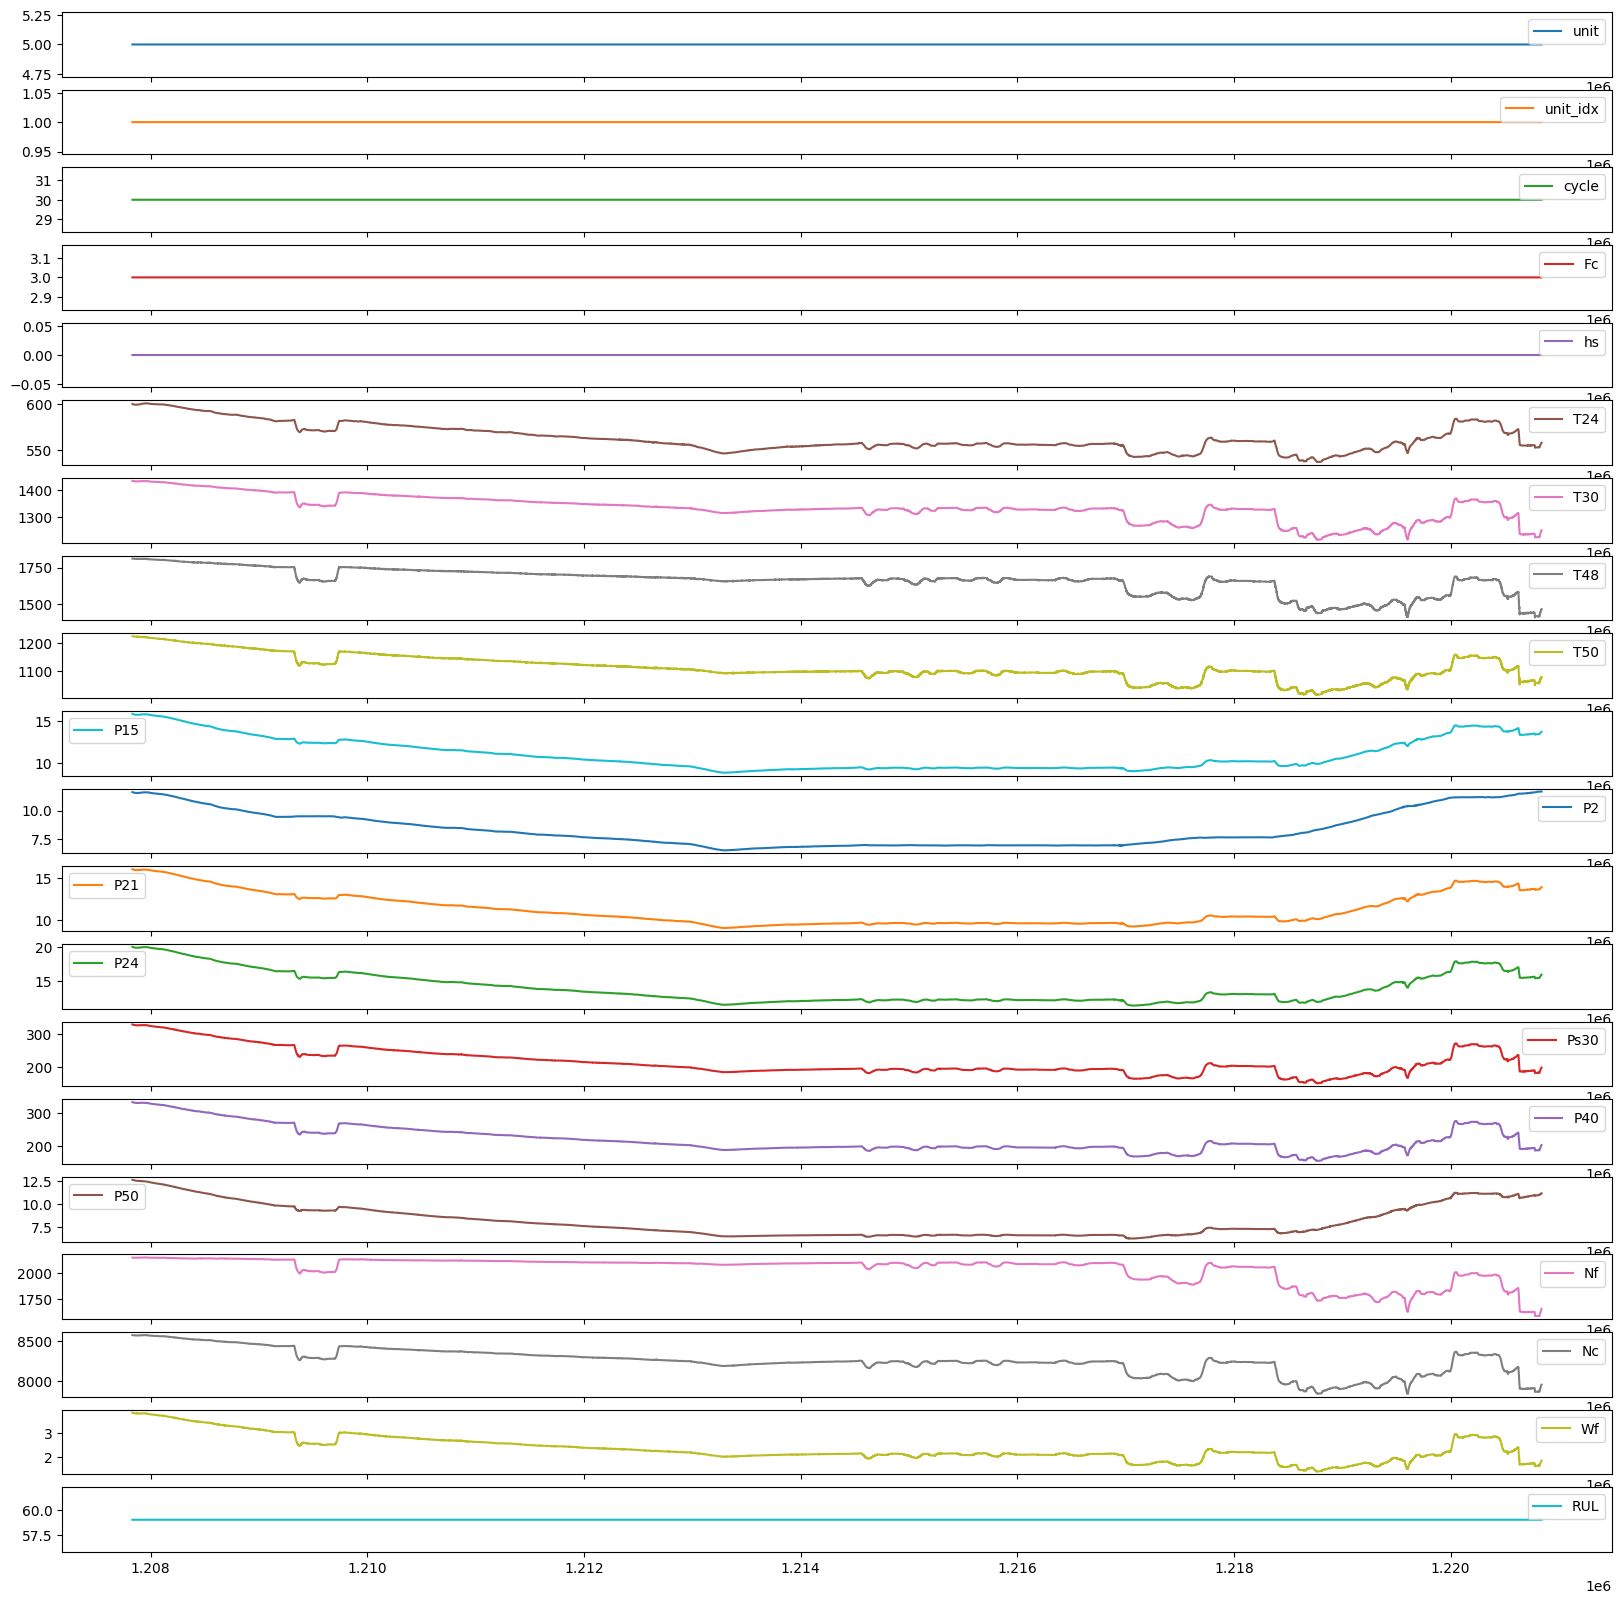

In [102]:
u5_c30 = NASAdataset_df_train_u5_c30.plot(subplots=True, figsize=(20,20))

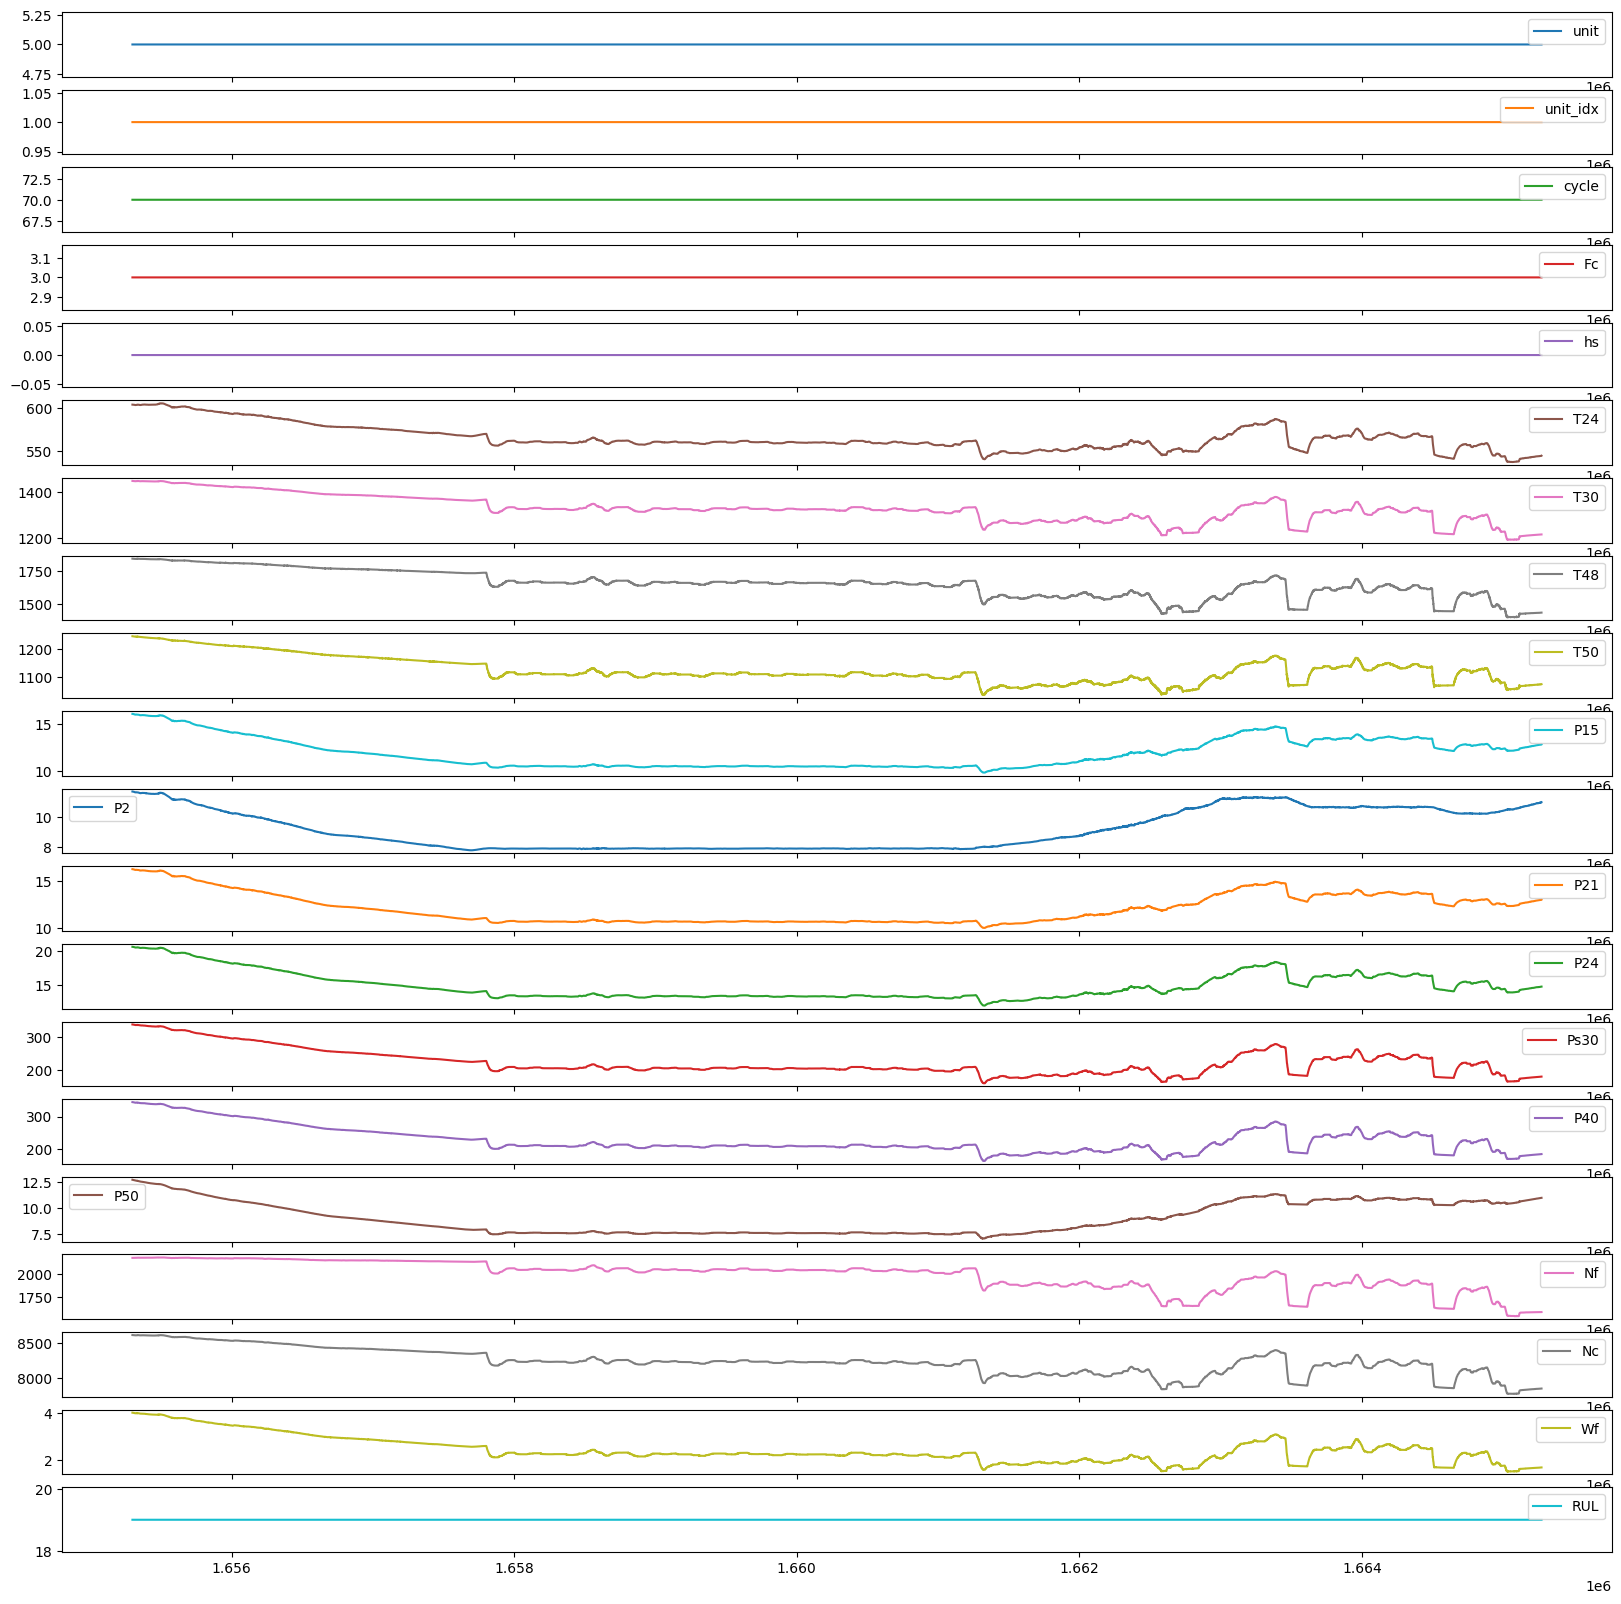

In [101]:
u5_c70 = NASAdataset_df_train_u5_c70.plot(subplots=True, figsize=(20,20))

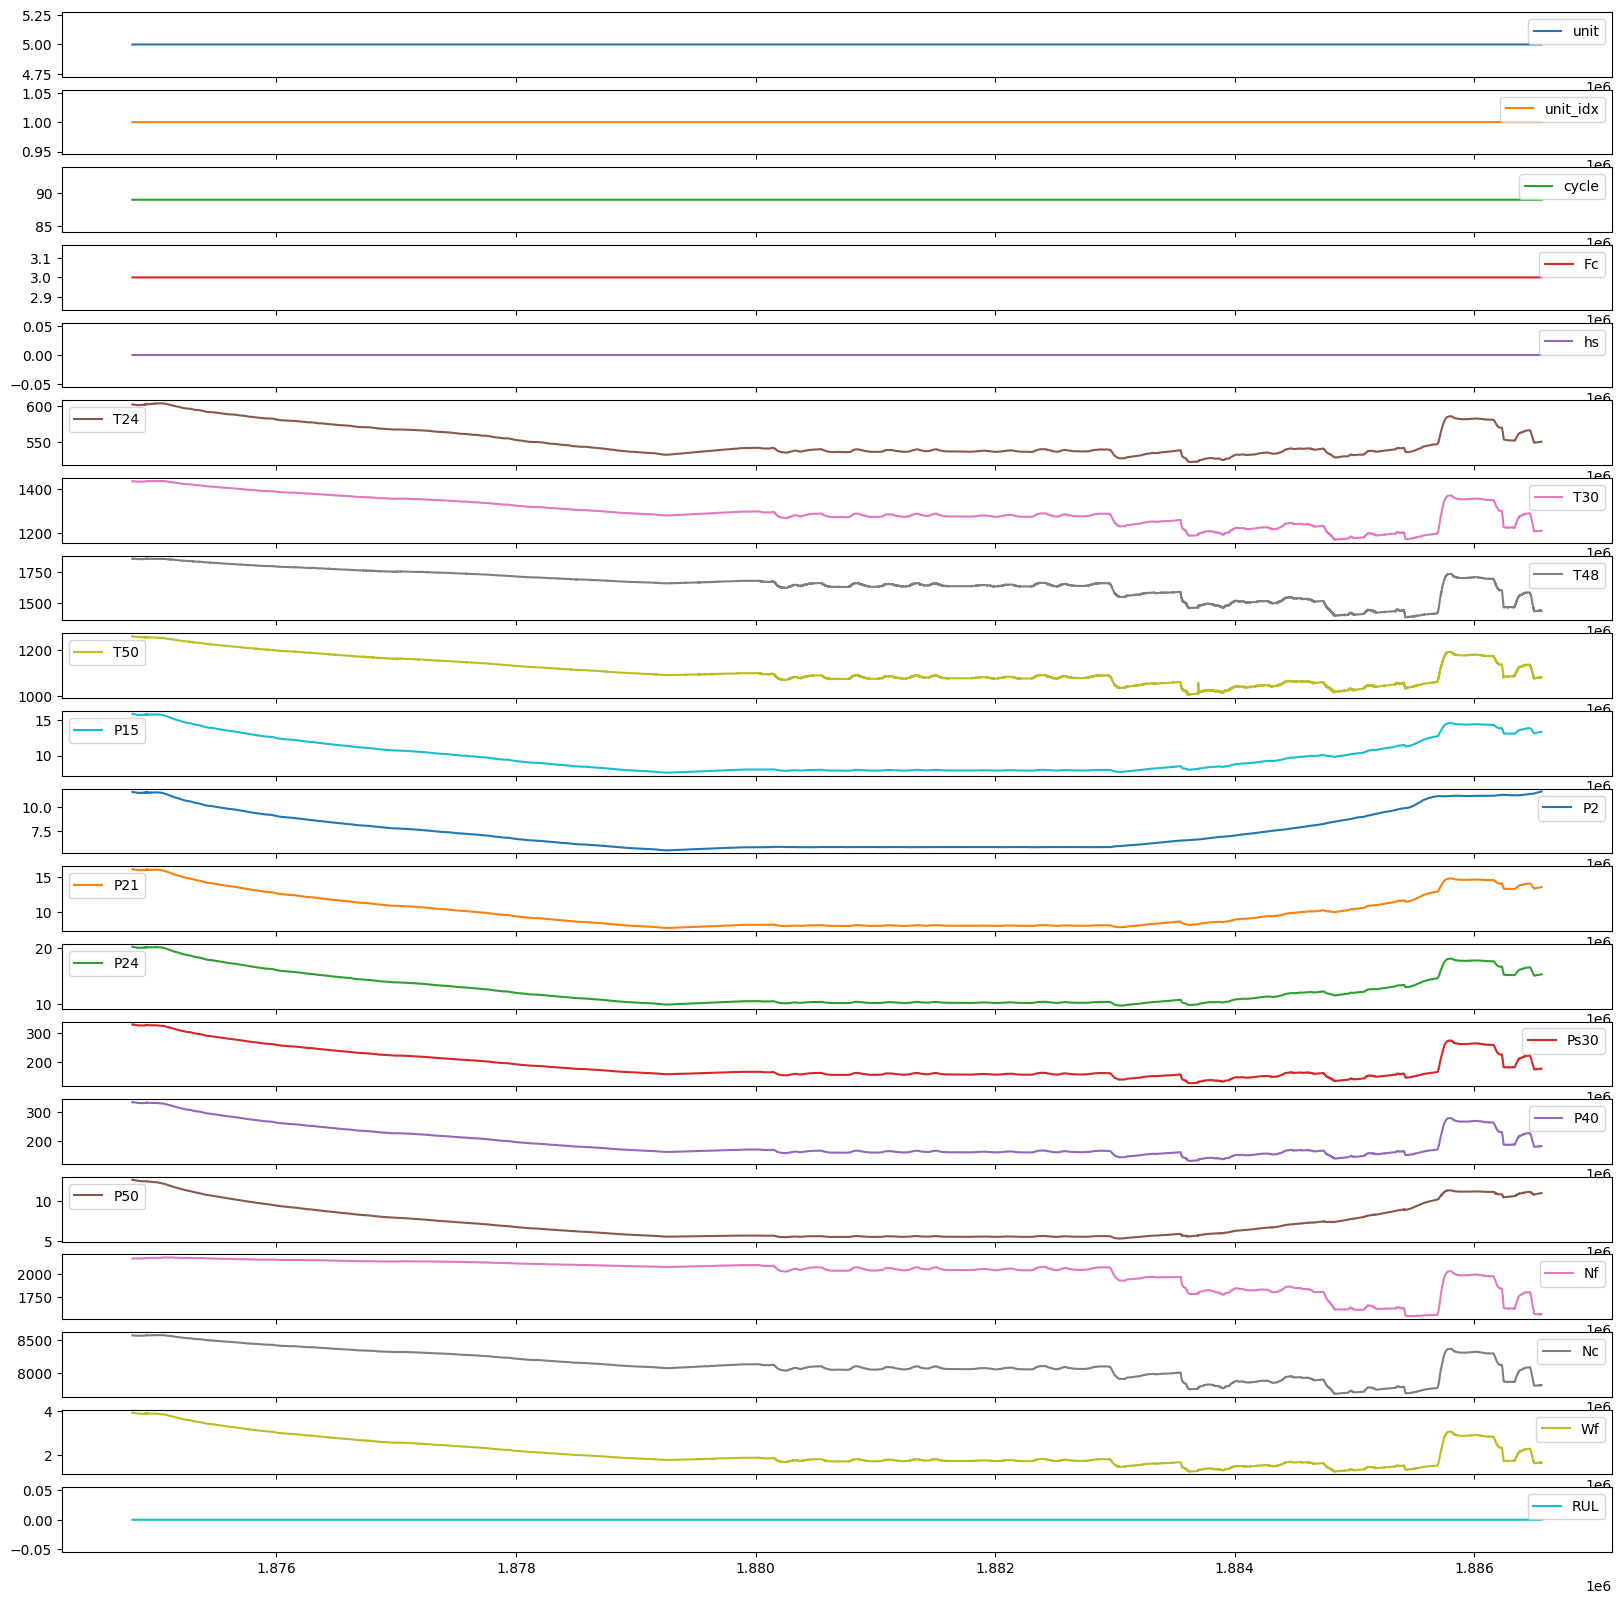

In [107]:
#fail
u5_c89 = NASAdataset_df_train_u5_c89.plot(subplots=True, figsize=(20,20))

In [75]:
# RUL analysis
maxrul_u = NASAdataset_df_train.groupby('unit').max().reset_index()
maxrul_u

,unit,unit_idx,cycle,Fc,hs,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,RUL
0,2.0,0.0,75.0,3.0,1.0,616.796557,1486.457251,1909.452866,1272.542428,16.918859,12.268619,17.176506,21.984966,371.823231,377.457779,13.193475,2263.476825,8740.188729,4.521983,74.0
1,5.0,1.0,89.0,3.0,1.0,608.792674,1458.611822,1870.644992,1261.478464,16.445422,12.165295,16.695860,21.104300,348.391997,353.937798,12.853226,2212.444056,8654.795910,4.110213,88.0
2,10.0,2.0,82.0,3.0,1.0,606.729148,1453.422438,1876.439179,1267.300756,16.284803,12.189874,16.532795,20.751570,342.672183,348.085341,12.797049,2205.483602,8638.457935,4.066605,81.0
3,18.0,4.0,71.0,3.0,1.0,616.714755,1487.274864,1912.816178,1276.669155,16.918259,12.268619,17.175898,21.978381,372.484460,378.155881,13.210040,2263.477056,8745.187108,4.539436,70.0
4,20.0,5.0,66.0,3.0,1.0,610.637816,1468.537464,1898.923768,1284.410062,16.374098,12.216071,16.623450,21.114727,354.267472,359.529337,12.993743,2222.218747,8678.287213,4.305223,65.0


In [80]:
#check if there are empty values
print(NASAdataset_df_train.isnull().sum())
print(NASAdataset_df_train.dtypes)

unit        0
unit_idx    0
cycle       0
Fc          0
hs          0
T24         0
T30         0
T48         0
T50         0
P15         0
P2          0
P21         0
P24         0
Ps30        0
P40         0
P50         0
Nf          0
Nc          0
Wf          0
RUL         0
dtype: int64
unit        float64
unit_idx    float64
cycle       float64
Fc          float64
hs          float64
T24         float64
T30         float64
T48         float64
T50         float64
P15         float64
P2          float64
P21         float64
P24         float64
Ps30        float64
P40         float64
P50         float64
Nf          float64
Nc          float64
Wf          float64
RUL         float64
dtype: object


<AxesSubplot:>

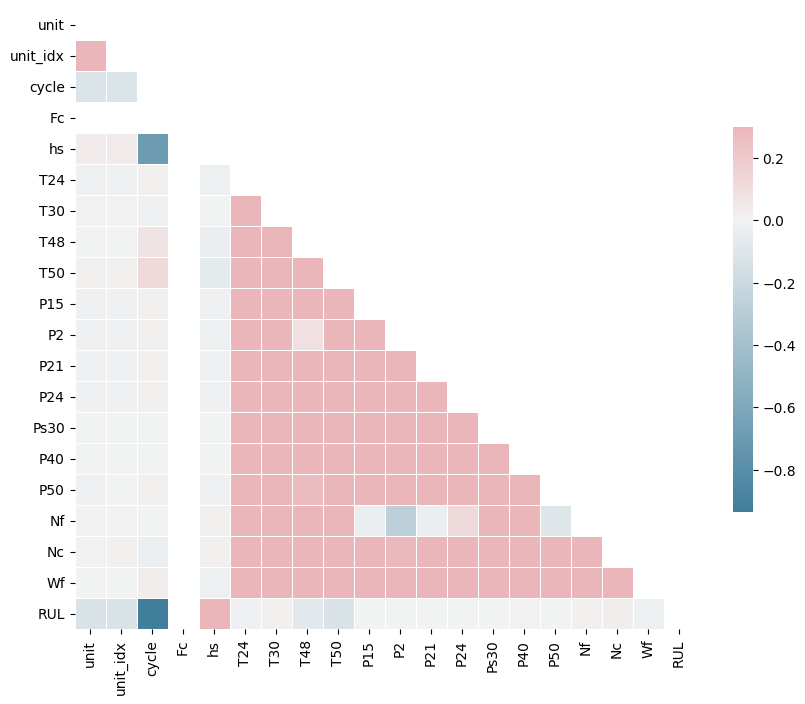

In [43]:
# Discovering Correlations
corr = NASAdataset_df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

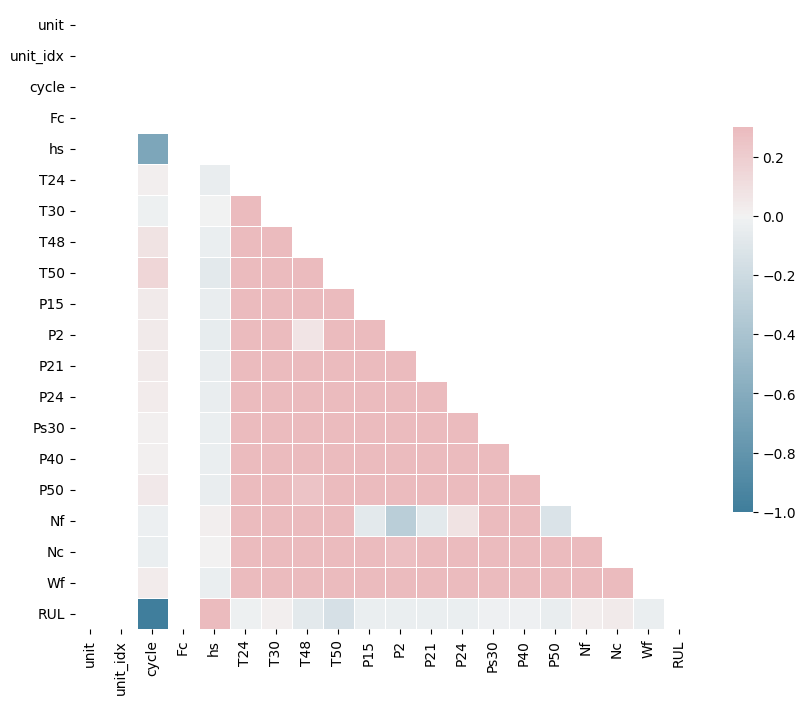

In [82]:
# Discovering Correlations for single unit
corr = NASAdataset_df_train_u5.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

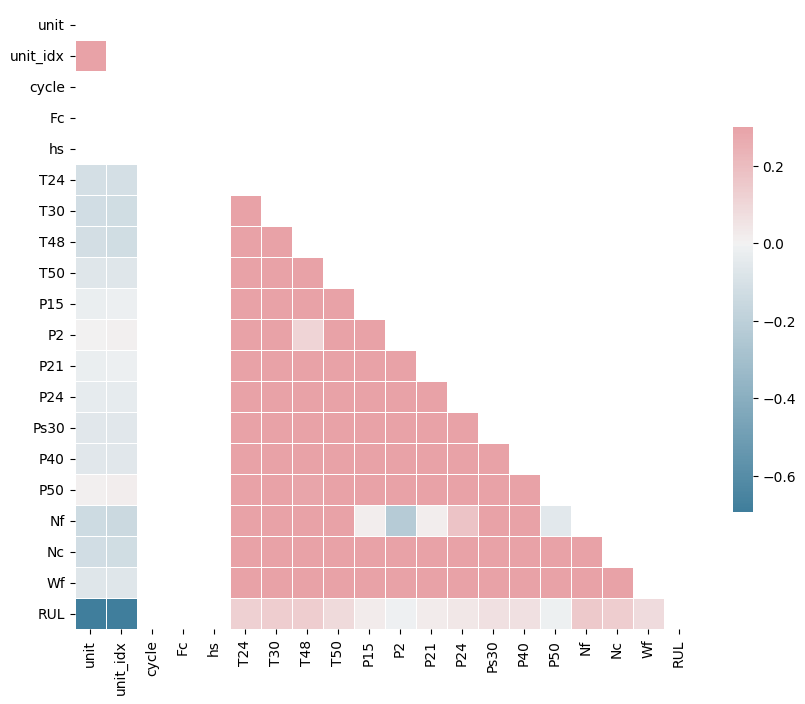

In [91]:
# Discovering Correlations
corr = NASAdataset_df_train_c30.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

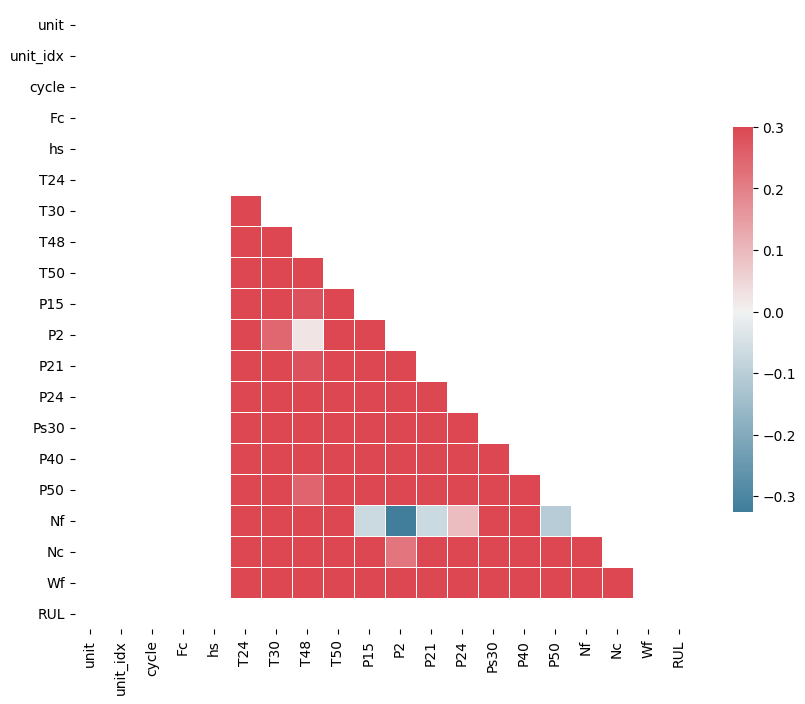

In [92]:
# Discovering Correlations
corr = NASAdataset_df_train_u5_c30.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
Sensor_dictionary={}
dict_list=["T24",
    "T30",
    "T48",
    "T50",
    "P15",
    "P2",
    "P21",
    "P24",
    "Ps30",
    "P40",
    "P50",
    "Nf",
    "Nc",
    "Wf"]
    
for x in dict_list :
    Sensor_dictionary[x]=x
    
Sensor_dictionary

{'T24': 'T24',
 'T30': 'T30',
 'T48': 'T48',
 'T50': 'T50',
 'P15': 'P15',
 'P2': 'P2',
 'P21': 'P21',
 'P24': 'P24',
 'Ps30': 'Ps30',
 'P40': 'P40',
 'P50': 'P50',
 'Nf': 'Nf',
 'Nc': 'Nc',
 'Wf': 'Wf'}

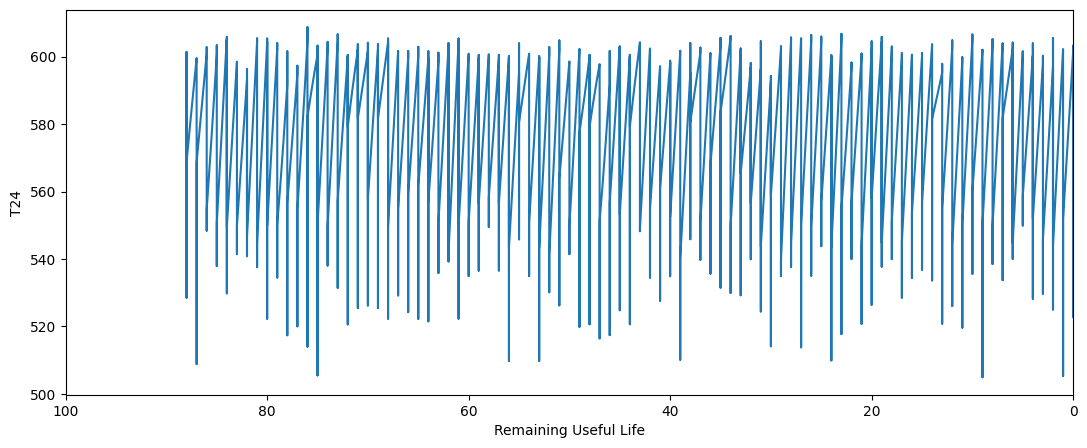

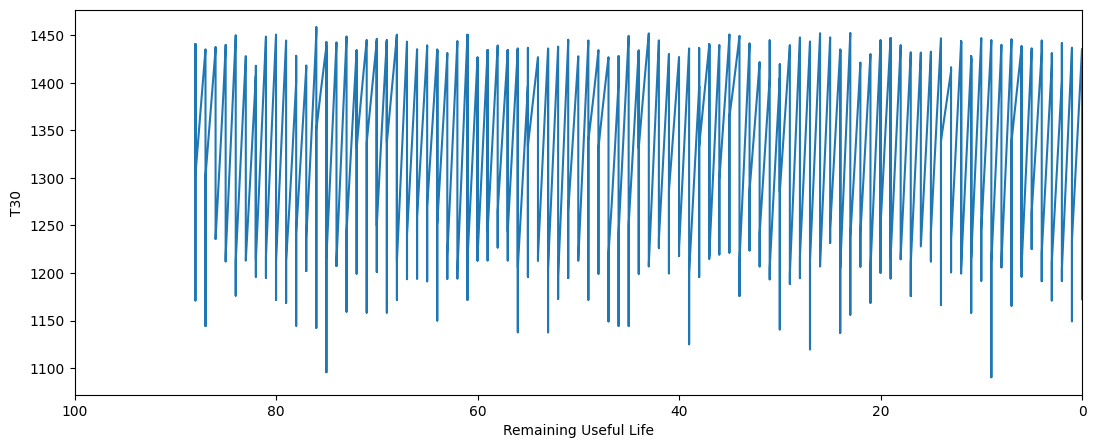

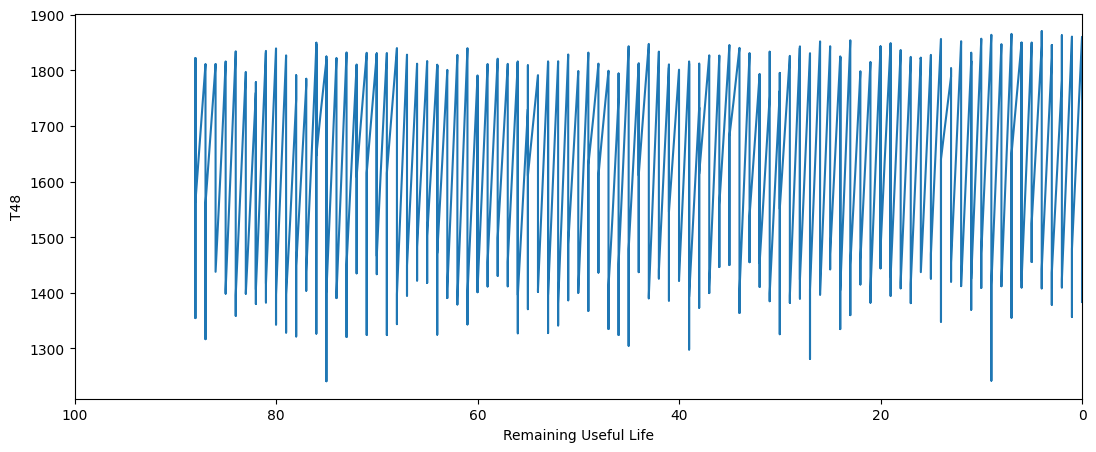

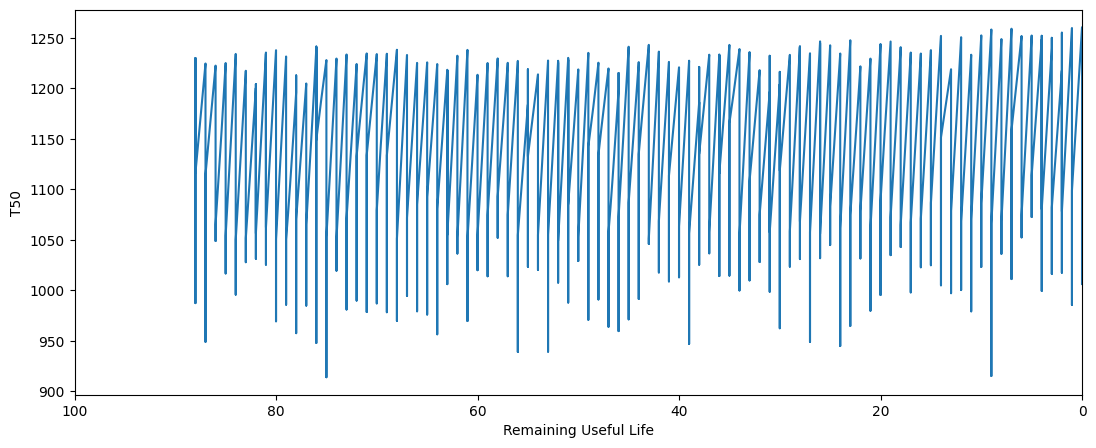

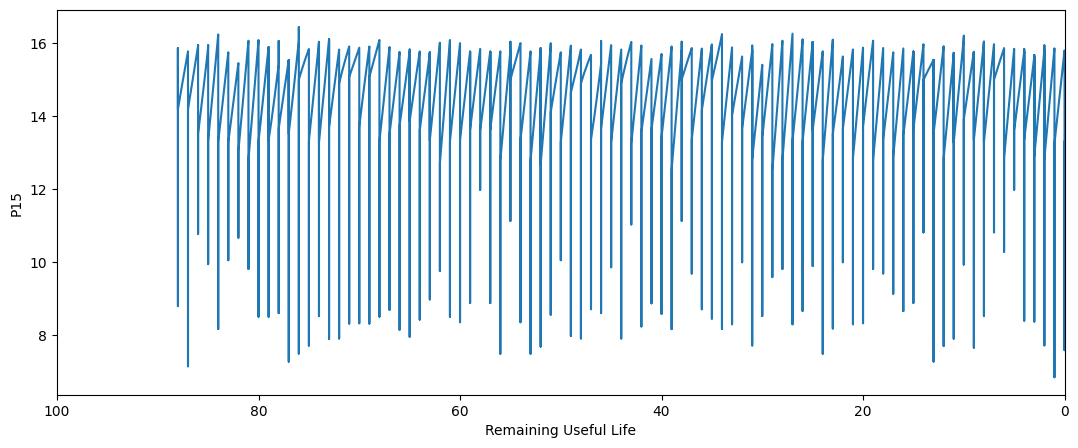

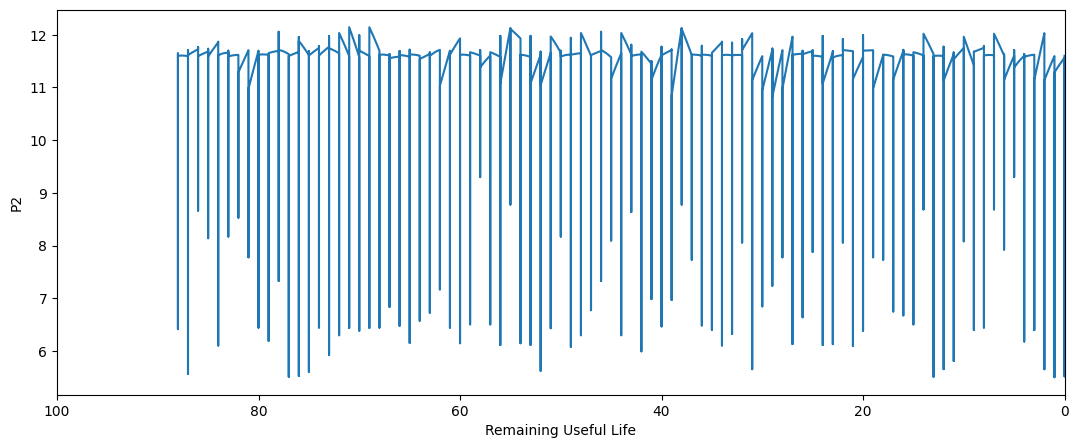

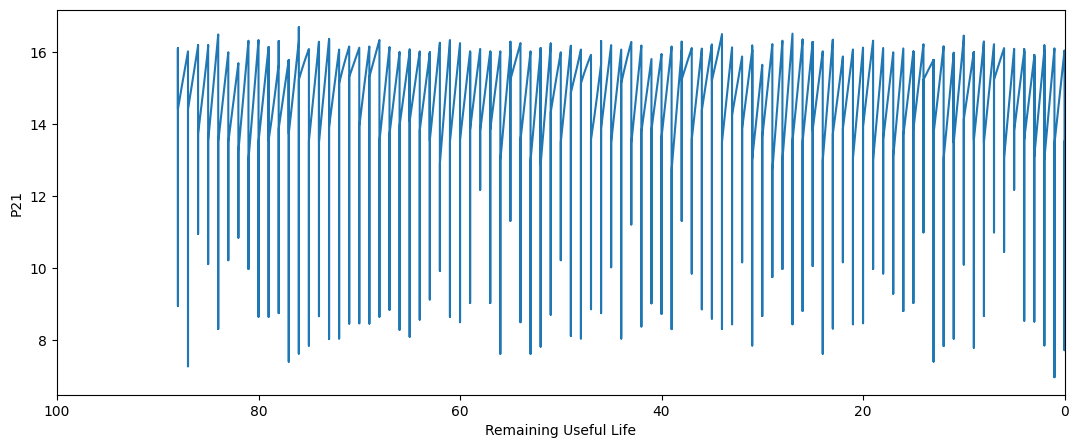

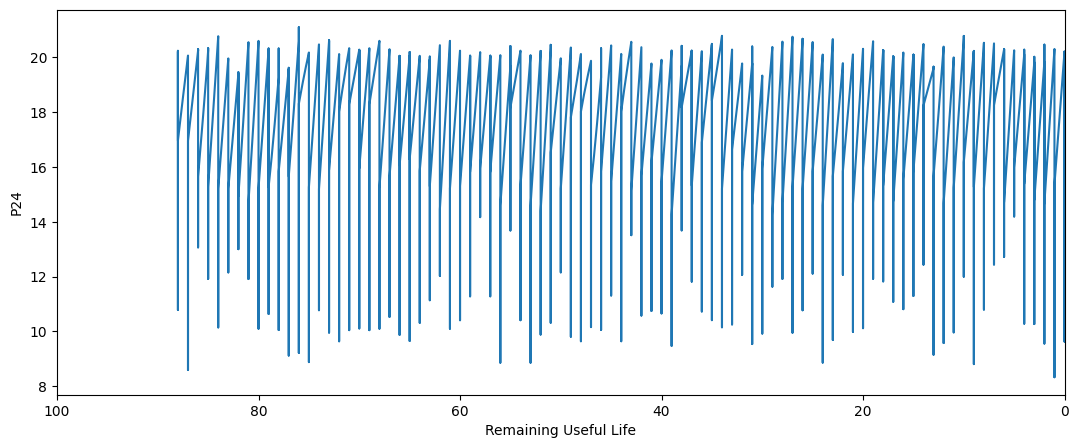

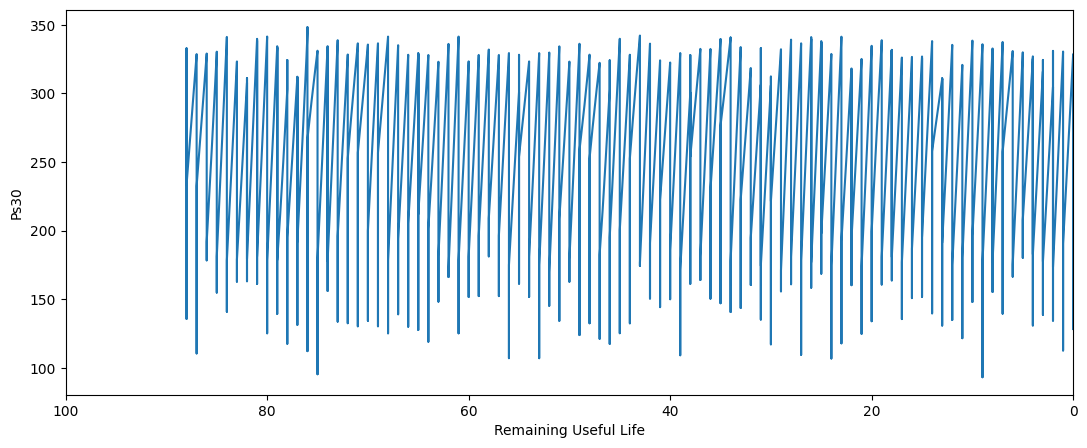

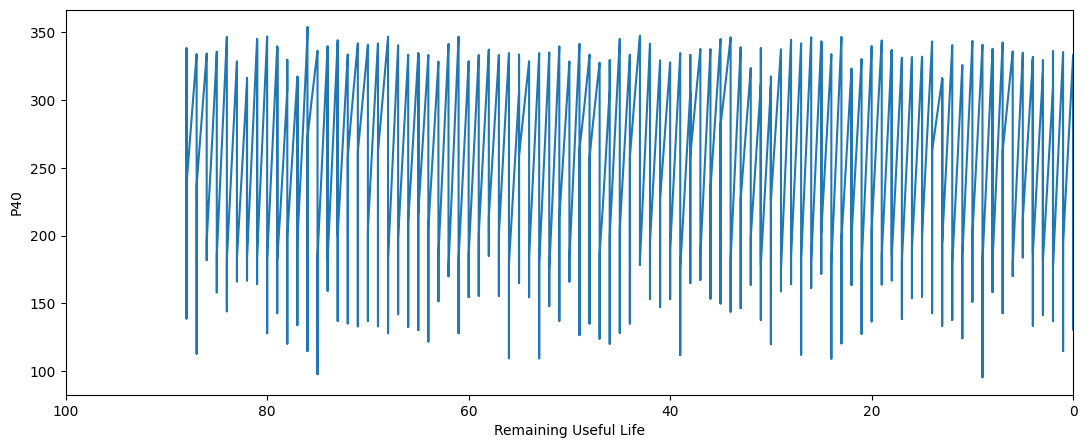

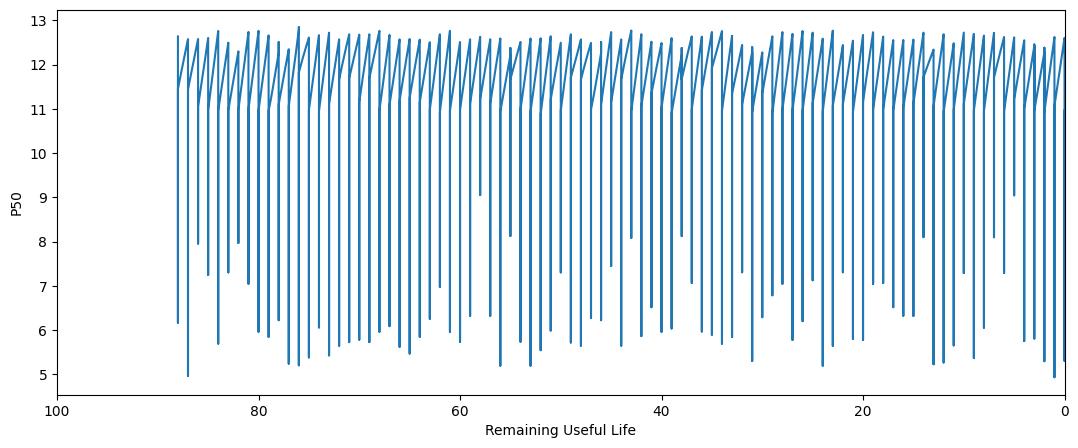

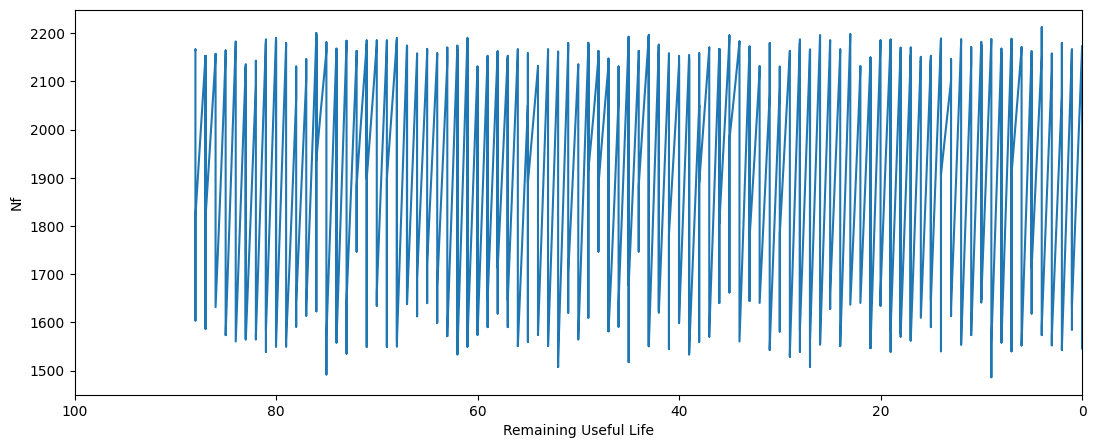

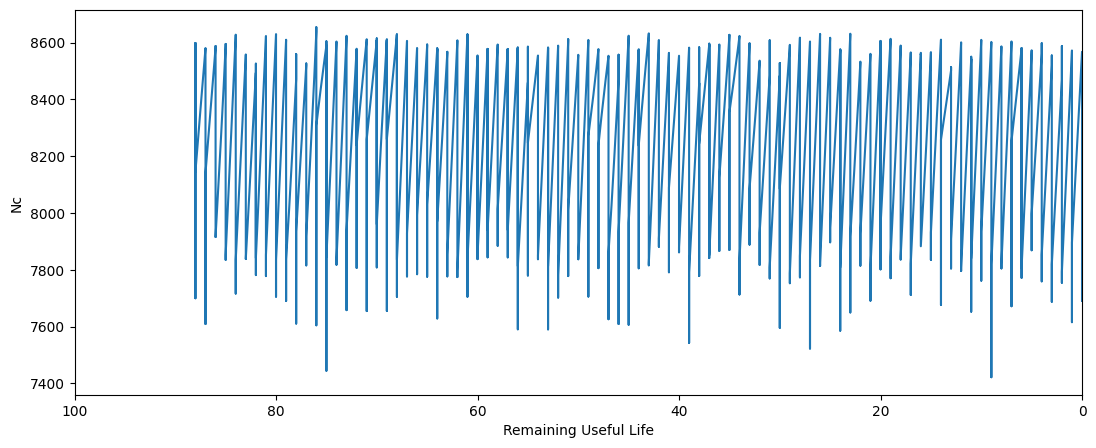

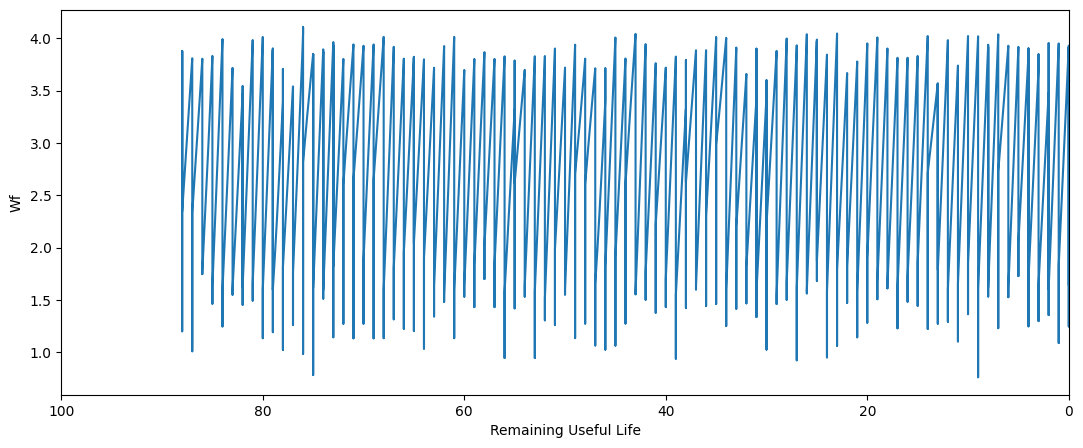

In [64]:
# Plot the evolution of features(from sensors) along with the evolution with RUL

def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    # for i in df['unit'].unique():
    #     plt.plot('RUL', signal_name, data=df[df['unit']==i].rolling(10).mean())
    plt.plot('RUL', signal_name, data=df[df['unit']==5].rolling(10).mean())


    plt.xlim(100, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

for x in dict_list:
    try:
        plot_signal(NASAdataset_df_train, Sensor_dictionary, x)
    except:
        pass